<a href="https://colab.research.google.com/github/xoxominji/22-1-ESAA-Practice/blob/main/0415_%EB%B0%95%EB%AF%BC%EC%A7%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [캐글필사]: Customers clustering: K-Means, DBSCAN and AP

## 1. Introduction

<군집(clustering) 적용 범위>
- 고객 분류
- 이미지 분할
- 도큐먼트 군집

<군집화의 유형>
1. 계층적 군집화 : 각 관측지를 하나의 최초 군집으로 지정한 후, 한번에 두개씩 하나의 군집으로 만들어, 모든 군집들이 하나의 군집이 될 때까지 군집들을 결합해 나가는 방법

2. **분리형 군집화(partitional clustering)** : 처음에 군집수인 k를 지정한 후, 관측치들을 무작위로 k개의 집단으로 분할하고 다양한 기준(평균값, 최빈값 등)을 이용하여 centroid를 수정해나가며 집단을 다시 재분류 하는 방법
  ex) K-means, DBSCAN, Affinity Propagation

최근 클러스팅 기법이 다양해지면서 특정 알고리즘이 우세한 경우는 없음. 데이터 특성, 조건, 예상값에 따라 선택하면 됨.

## 2. Reading data

In [1]:
# 기본 라이브러리 불러오
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

print("pandas version: {}".format(pd.__version__))
print("numpy version: {}".format(np.__version__))
print("seaborn version: {}".format(sns.__version__))

pandas version: 1.3.5
numpy version: 1.21.5
seaborn version: 0.11.2


In [2]:
mall_data = pd.read_csv('/content/drive/MyDrive/2022-1 ESAA/데이터/Mall_Customers.csv')

print('There are {} rows and {} columns in our dataset'.format(mall_data.shape[0],mall_data.shape[1]))

There are 200 rows and 5 columns in our dataset


In [3]:
mall_data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
mall_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


<5 변수(columns)>

- Customer ID - 숫자형 - unique customer number, 정수
- Gender - 범주형 - binary (Male/Female)
- Age - 숫자형 - 정수
- Annual Income (k$) - 숫자형 - 정수
- Spending Score (1-100) - 숫자형 - 정수

> 범주형 변수 1개 있음(gender). 군집화를 위해 원핫인코딩을 진행할 수 있지만, 추천하지는 않음

In [5]:
mall_data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [6]:
mall_data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

결측치 없음. 분석을 단순화하지만 데이터 정리가 없다는 것은 비현실적

## 3. Exploratory Data Analysis (EDA)

### 3.1 Distributions (분포 확인)

범주형 변수에 대한 분포를 우선 확인한다

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


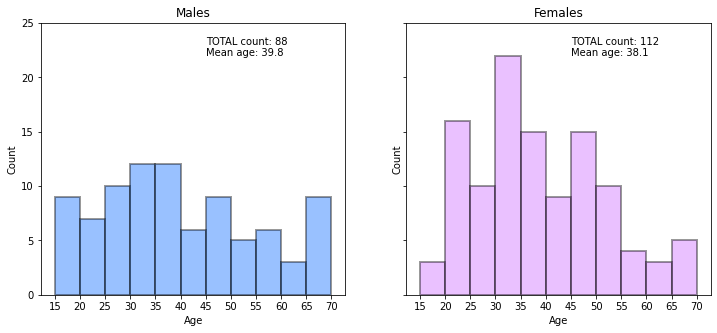

In [7]:
males_age = mall_data[mall_data['Gender']=='Male']['Age'] # subset with males age
females_age = mall_data[mall_data['Gender']=='Female']['Age'] # subset with females age

age_bins = range(15,75,5)

# males 히스토그램
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharey=True)
sns.distplot(males_age, bins=age_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(age_bins)
ax1.set_ylim(top=25)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(45,23, "TOTAL count: {}".format(males_age.count()))
ax1.text(45,22, "Mean age: {:.1f}".format(males_age.mean()))

# females 히스토그램
sns.distplot(females_age, bins=age_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(age_bins)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(45,23, "TOTAL count: {}".format(females_age.count()))
ax2.text(45,22, "Mean age: {:.1f}".format(females_age.mean()))

plt.show()

> 남성 고객의 평균 연령 > 여성 고객의 평균 연령. 남성 연령의 분포는 여성보다 더 균일하며, 여성 고객에서 가장 큰 연령층은 30-35세임을 관찰할 수 있음.

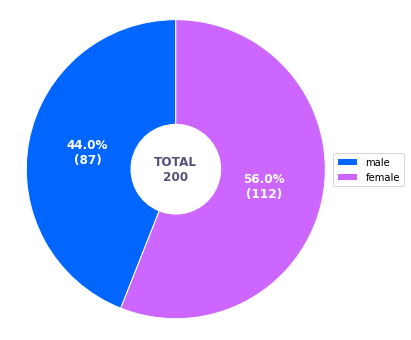

In [8]:
def labeler(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

sizes = [males_age.count(),females_age.count()] # wedge sizes

fig0, ax1 = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax1.pie(sizes,
                                   autopct=lambda pct: labeler(pct, sizes),
                                   radius=1,
                                   colors=['#0066ff','#cc66ff'],
                                   startangle=90,
                                   textprops=dict(color="w"),
                                   wedgeprops=dict(width=0.7, edgecolor='w'))

ax1.legend(wedges, ['male','female'],
           loc='center right',
           bbox_to_anchor=(0.7, 0, 0.5, 1))

plt.text(0,0, 'TOTAL\n{}'.format(mall_data['Age'].count()),
         weight='bold', size=12, color='#52527a',
         ha='center', va='center')

plt.setp(autotexts, size=12, weight='bold')
ax1.axis('equal')  # Equal aspect ratio
plt.show()

> 남성 고객 < 여성 고객

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


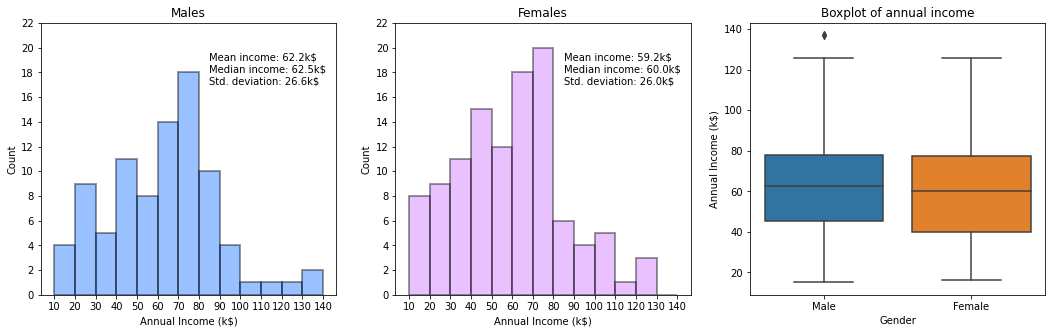

In [9]:
males_income = mall_data[mall_data['Gender']=='Male']['Annual Income (k$)'] # subset with males income
females_income = mall_data[mall_data['Gender']=='Female']['Annual Income (k$)'] # subset with females income

my_bins = range(10,150,10)

# males histogram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
sns.distplot(males_income, bins=my_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(my_bins)
ax1.set_yticks(range(0,24,2))
ax1.set_ylim(0,22)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(85,19, "Mean income: {:.1f}k$".format(males_income.mean()))
ax1.text(85,18, "Median income: {:.1f}k$".format(males_income.median()))
ax1.text(85,17, "Std. deviation: {:.1f}k$".format(males_income.std()))

# females histogram
sns.distplot(females_income, bins=my_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(my_bins)
ax2.set_yticks(range(0,24,2))
ax2.set_ylim(0,22)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(85,19, "Mean income: {:.1f}k$".format(females_income.mean()))
ax2.text(85,18, "Median income: {:.1f}k$".format(females_income.median()))
ax2.text(85,17, "Std. deviation: {:.1f}k$".format(females_income.std()))

# boxplot
sns.boxplot(x='Gender', y='Annual Income (k$)', data=mall_data, ax=ax3)
ax3.set_title('Boxplot of annual income')
plt.show()


> 남성의 평균 소득 > 여성의 평균 소득. 남성 그룹의 연소득에서 특이치가 하나 보임($140k)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


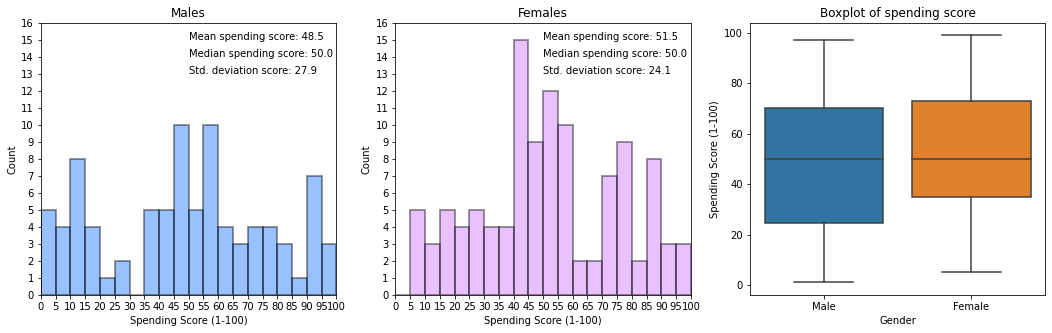

In [10]:
males_spending = mall_data[mall_data['Gender']=='Male']['Spending Score (1-100)'] # subset with males age
females_spending = mall_data[mall_data['Gender']=='Female']['Spending Score (1-100)'] # subset with females age

spending_bins = range(0,105,5)

# males histogram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
sns.distplot(males_spending, bins=spending_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(spending_bins)
ax1.set_xlim(0,100)
ax1.set_yticks(range(0,17,1))
ax1.set_ylim(0,16)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(50,15, "Mean spending score: {:.1f}".format(males_spending.mean()))
ax1.text(50,14, "Median spending score: {:.1f}".format(males_spending.median()))
ax1.text(50,13, "Std. deviation score: {:.1f}".format(males_spending.std()))

# females histogram
sns.distplot(females_spending, bins=spending_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(spending_bins)
ax2.set_xlim(0,100)
ax2.set_yticks(range(0,17,1))
ax2.set_ylim(0,16)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(50,15, "Mean spending score: {:.1f}".format(females_spending.mean()))
ax2.text(50,14, "Median spending score: {:.1f}".format(females_spending.median()))
ax2.text(50,13, "Std. deviation score: {:.1f}".format(females_spending.std()))

# boxplot
sns.boxplot(x='Gender', y='Spending Score (1-100)', data=mall_data, ax=ax3)
ax3.set_title('Boxplot of spending score')
plt.show()

plt.show()

> 남성의 평균 지출 점수 < 여성의 평균 지출 점수

In [11]:
medians_by_age_group = mall_data.groupby(["Gender",pd.cut(mall_data['Age'], age_bins)]).median()
medians_by_age_group.index = medians_by_age_group.index.set_names(['Gender', 'Age_group'])
medians_by_age_group.reset_index(inplace=True)

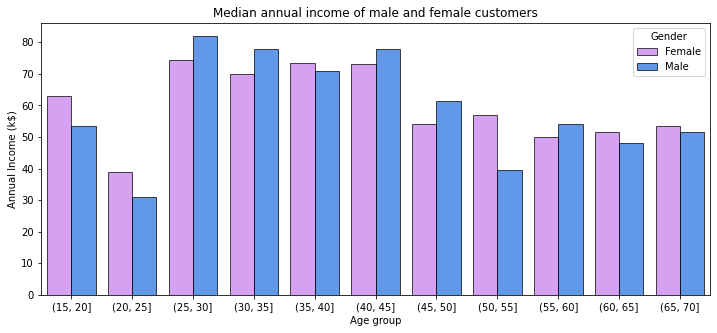

In [12]:
fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(x='Age_group', y='Annual Income (k$)', hue='Gender', data=medians_by_age_group,
            palette=['#cc66ff','#0066ff'],
            alpha=0.7,edgecolor='k',
            ax=ax)
ax.set_title('Median annual income of male and female customers')
ax.set_xlabel('Age group')
plt.show()

> 연령대별 중위소득 중 가장 부유한 연령대: 25-45세

> 여성과 남성 성별 간 연령대별 중위소득에 가장 큰 차이는 25-30세(남성이 더 부자)와 50-55세(여성이 더 부자)임

### 3.2 Correlations 상관관계

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


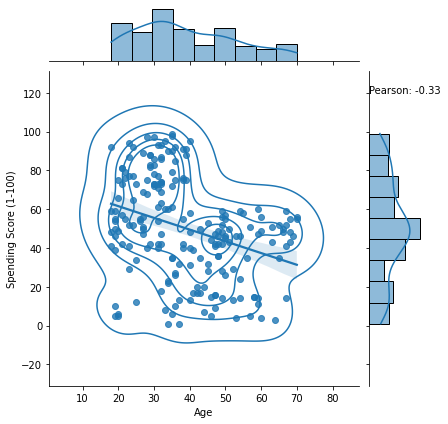

In [13]:
from scipy.stats import pearsonr

# 피어슨 상관계수 계산
corr, _ = pearsonr(mall_data['Age'], mall_data['Spending Score (1-100)'])

jp = (sns.jointplot('Age', 'Spending Score (1-100)', data=mall_data,
                    kind='reg')).plot_joint(sns.kdeplot, zorder=0, n_levels=6)

plt.text(0,120, 'Pearson: {:.2f}'.format(corr))
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


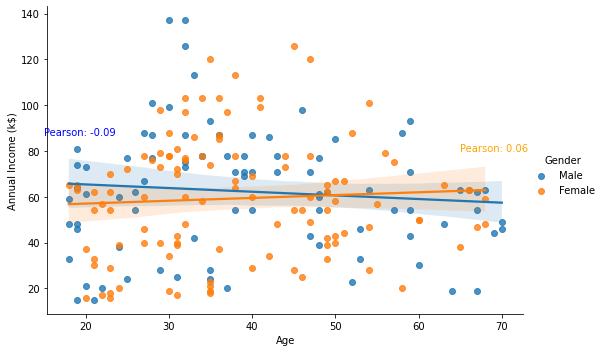

In [14]:
# age vs. annual income in terms of gender
corr1, _ = pearsonr(males_age.values, males_income.values)
corr2, _ = pearsonr(females_age.values, females_income.values)

sns.lmplot('Age', 'Annual Income (k$)', data=mall_data, hue='Gender',
          aspect=1.5)

plt.text(15,87, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(65,80, 'Pearson: {:.2f}'.format(corr2), color='orange')

plt.show()

> 두 성별 그룹에 대해 고객의 연령과 연간 수입 사이에는 무시할 수 있는 상관관계가 있음

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


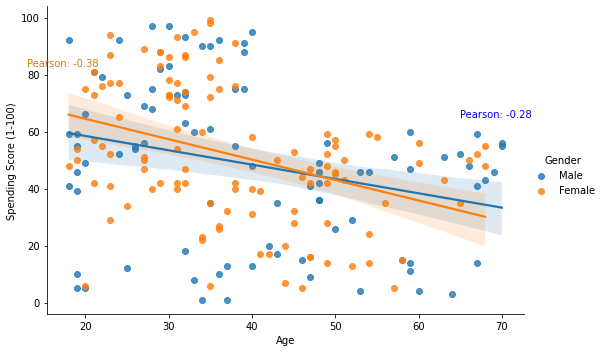

In [15]:
# age vs. spending score in terms of gender
corr1, _ = pearsonr(males_age.values, males_spending.values)
corr2, _ = pearsonr(females_age.values, females_spending.values)

sns.lmplot('Age', 'Spending Score (1-100)', data=mall_data, hue='Gender',
          aspect=1.5)

plt.text(65,65, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(13,83, 'Pearson: {:.2f}'.format(corr2), color='#d97900')

plt.show()

> 연령과 지출 점수 사이에는 두 성별 그룹에 대한 약한 음의 상관관계가 있음

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


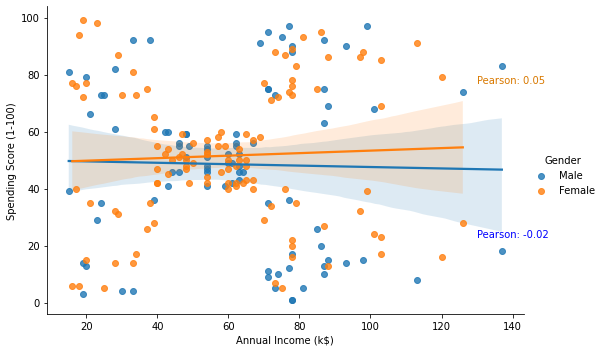

In [16]:
# annual income vs. spending score in terms of gender
corr1, _ = pearsonr(males_income.values, males_spending.values)
corr2, _ = pearsonr(females_income.values, females_spending.values)

sns.lmplot('Annual Income (k$)', 'Spending Score (1-100)', data=mall_data, hue='Gender',
          aspect=1.5)

plt.text(130,23, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(130,77, 'Pearson: {:.2f}'.format(corr2), color='#d97900')

plt.show()

> 두 성별 그룹에 대한 고객의 연간 수입과 소비 점수 사이에는 무시할 수 있는 상관관계가 있음

## 4. Clustering

### 4.1 K-means

<과정>
1. 시드 포인트를 사용하여 샘플을 초기 그룹으로 나누기. (시드 포인트에 가장 가까운 샘플로 초기 클러스터 생성)
2. 그룹의 중심점(중심점)까지의 표본 거리를 계산하고 해당 군집에 가장 가까운 표본 할당
3. 새로 생성된(업데이트된) 군집 중심체를 계산하

- 알고리즘이 군집으로 수렴될 때까지 2단계와 3단계를 반복

<주요 파라미터>
1. Initialization criteria : "k-means++", "random" 
2. Number of clusters
  - 엘보우 기법
  - 실루엣 점수 계산
  - MML
  - MDL
  - BIC
  - AIC
  - Dirichlet Process
  - Gap statistics
3. Distance metric (사이킷런에서는 중요하지 않음)
  - 마할라노비스 거리
  - Itakura-Saito
  - L1
  - 코사인
  - Bregman


In [17]:
from sklearn.cluster import KMeans 

In [18]:
X_numerics = mall_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']] # 숫자형 변수로만 따로

최적의 군집 수 설정을 위해 엘보 방법 사용

In [19]:
from sklearn.metrics import silhouette_score
n_clusters = [2,3,4,5,6,7,8,9,10] # number of clusters
clusters_inertia = [] # inertia of clusters
s_scores = [] # 실루엣 점수

for n in n_clusters:
    KM_est = KMeans(n_clusters=n, init='k-means++').fit(X_numerics)
    clusters_inertia.append(KM_est.inertia_)    # data for the elbow method
    silhouette_avg = silhouette_score(X_numerics, KM_est.labels_)
    s_scores.append(silhouette_avg) # data for the silhouette score method

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


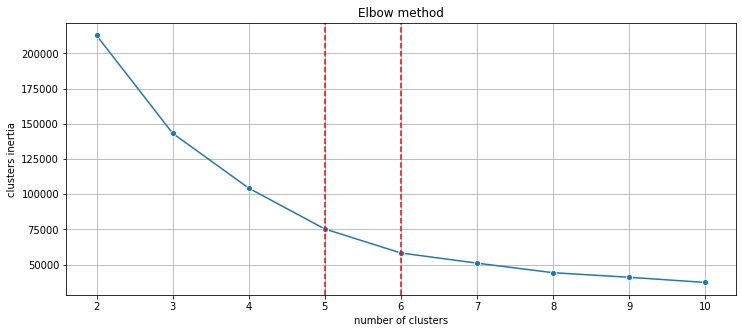

In [20]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(n_clusters, clusters_inertia, marker='o', ax=ax)
ax.set_title("Elbow method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("clusters inertia")
ax.axvline(5, ls="--", c="red")
ax.axvline(6, ls="--", c="red")
plt.grid()
plt.show()

> 엘보 지점이 명확하게 보이지 않음. 5, 6개가 적절해 보임.

> 실루엣 점수를 상세히 볼 것

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


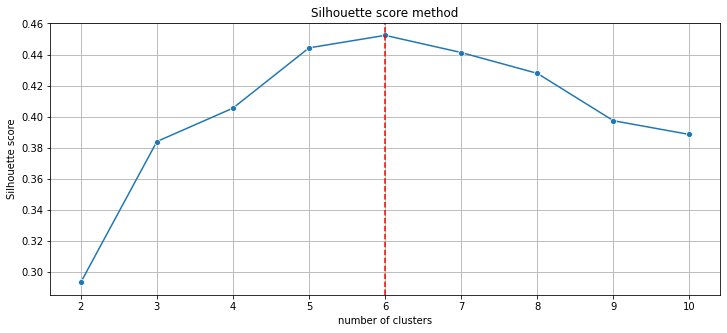

In [21]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(n_clusters, s_scores, marker='o', ax=ax)
ax.set_title("Silhouette score method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("Silhouette score")
ax.axvline(6, ls="--", c="red")
plt.grid()
plt.show()

> 실루엣 점수 또한 5, 6개에서 상대적으로 좋은 것으로 보임. 두 경우를 비교할 필요가 있음

**군집 5개**

In [22]:
KM_5_clusters = KMeans(n_clusters=5, init='k-means++').fit(X_numerics) 

KM5_clustered = X_numerics.copy()
KM5_clustered.loc[:,'Cluster'] = KM_5_clusters.labels_ # append labels to points

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


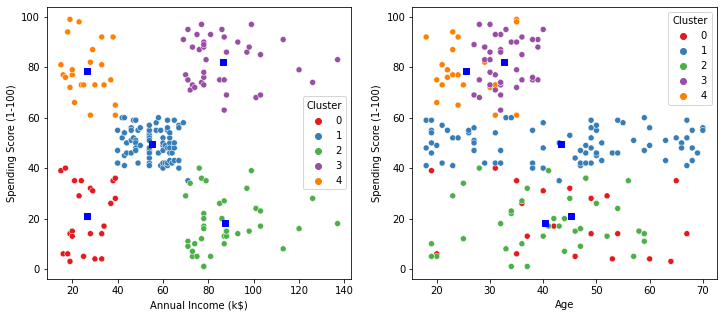

In [23]:
fig1, (axes) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)', data=KM5_clustered,
                hue='Cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot('Age', 'Spending Score (1-100)', data=KM5_clustered,
                hue='Cluster', palette='Set1', ax=axes[1], legend='full')

axes[0].scatter(KM_5_clusters.cluster_centers_[:,1],KM_5_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(KM_5_clusters.cluster_centers_[:,0],KM_5_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

- clients with **low** annual income and **high** spending score
- clients with **medium** annual income and **medium** spending score
- clients with **high** annual income and **low** spending score
- clients with **high** annual income and **high** spending score
- clients with **low** annual income and **low** spending score

> 고객 연령에 따라 구분되는 그룹은 없음

군집의 수:

In [24]:
KM_clust_sizes = KM5_clustered.groupby('Cluster').size().to_frame()
KM_clust_sizes.columns = ["KM_size"]
KM_clust_sizes

,KM_size
Cluster,
0,23
1,78
2,37
3,39
4,23


> 가장 큰 클러스터: 클러스터 1번 (관측치 79개, "중간형-중간형")


> 가장 작은 클러스터: 클러스터 3번(관측치 23개, "높은-높은형"), 클러스터 0번(관측치 23개, "낮은-높은형") 

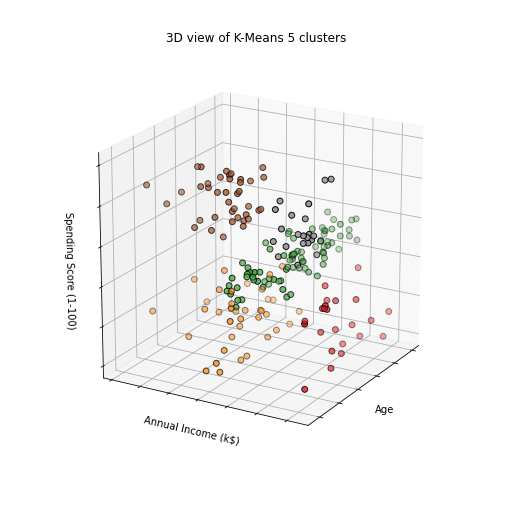

In [25]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7, 7))
ax = Axes3D(fig, rect=[0, 0, .99, 1], elev=20, azim=210)
ax.scatter(KM5_clustered['Age'],
           KM5_clustered['Annual Income (k$)'],
           KM5_clustered['Spending Score (1-100)'],
           c=KM5_clustered['Cluster'],
           s=35, edgecolor='k', cmap=plt.cm.Set1)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
ax.set_title('3D view of K-Means 5 clusters')
ax.dist = 12

plt.show()

In [26]:
import plotly as py
import plotly.graph_objs as go

def tracer(db, n, name):
    '''
    This function returns trace object for Plotly
    '''
    return go.Scatter3d(
        x = db[db['Cluster']==n]['Age'],
        y = db[db['Cluster']==n]['Spending Score (1-100)'],
        z = db[db['Cluster']==n]['Annual Income (k$)'],
        mode = 'markers',
        name = name,
        marker = dict(
            size = 5
        )
     )

trace0 = tracer(KM5_clustered, 0, 'Cluster 0')
trace1 = tracer(KM5_clustered, 1, 'Cluster 1')
trace2 = tracer(KM5_clustered, 2, 'Cluster 2')
trace3 = tracer(KM5_clustered, 3, 'Cluster 3')
trace4 = tracer(KM5_clustered, 4, 'Cluster 4')

data = [trace0, trace1, trace2, trace3, trace4]

layout = go.Layout(
    title = 'Clusters by K-Means',
    scene = dict(
            xaxis = dict(title = 'Age'),
            yaxis = dict(title = 'Spending Score'),
            zaxis = dict(title = 'Annual Income')
        )
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

**군집 6개**

In [27]:
KM_6_clusters = KMeans(n_clusters=6, init='k-means++').fit(X_numerics) # initialise and fit K-Means model

KM6_clustered = X_numerics.copy()
KM6_clustered.loc[:,'Cluster'] = KM_6_clusters.labels_ # append labels to points

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



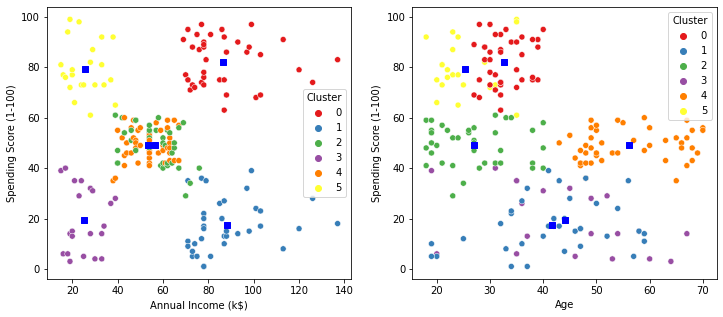

In [28]:
fig11, (axes) = plt.subplots(1,2,figsize=(12,5))

sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)', data=KM6_clustered,
                hue='Cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot('Age', 'Spending Score (1-100)', data=KM6_clustered,
                hue='Cluster', palette='Set1', ax=axes[1], legend='full')

# plotting centroids
axes[0].scatter(KM_6_clusters.cluster_centers_[:,1], KM_6_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(KM_6_clusters.cluster_centers_[:,0], KM_6_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

- younger clients with **medium** annual and **medium** spending score
- clients with **high** annual income and **low** spending score
- younger clients with **medium** annual and **medium** spending score
- clients with **high** annual income and **high** spending score
- clients with **low** annual income and **low** spending score
- clients with **low** annual income and **high** spending score

> 고객 연령에 따라 구분되는 그룹은 없음



In [29]:
# 군집의 수:
KM6_clust_sizes = KM6_clustered.groupby('Cluster').size().to_frame()
KM6_clust_sizes.columns = ["KM_size"]
KM6_clust_sizes

,KM_size
Cluster,
0,39
1,35
2,38
3,21
4,45
5,22


In [30]:
# Plotly interactive 3D plot

trace0 = tracer(KM6_clustered, 0, 'Cluster 0')
trace1 = tracer(KM6_clustered, 1, 'Cluster 1')
trace2 = tracer(KM6_clustered, 2, 'Cluster 2')
trace3 = tracer(KM6_clustered, 3, 'Cluster 3')
trace4 = tracer(KM6_clustered, 4, 'Cluster 4')
trace5 = tracer(KM6_clustered, 5, 'Cluster 5')

data = [trace0, trace1, trace2, trace3, trace4, trace5]

layout = go.Layout(
    title = 'Clusters by K-Means',
    scene = dict(
            xaxis = dict(title = 'Age'),
            yaxis = dict(title = 'Spending Score'),
            zaxis = dict(title = 'Annual Income')
        )
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

### 4.2 DBSCAN

: Density-Based Spatial Clustering of Applications with Noise (밀도 기반)

<주요 파라미터>
- Eps:거리
- MinPts: 앱실론 거리 내 최소 갯수

거리 함수는 사용자가 지정 가능

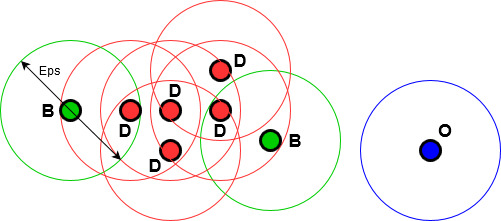

<작동 방법>
- "밀도 영역"은 모든 점 사이의 거리(Eps)에 따라 최소 개수의 점으로 생성
- 이 거리 내에 있지만 다른 점의 최소 개수에 가깝지 않은 점은 "경계점"으로 처리
- 잡음 또는 특이치: 예) 윗 그림(MinPts=3)에서 적색점(D)은 "밀도 영역"에 있으며, 각 영역에는 거리 Eps 내에 최소 3개의 이웃이 있음. 녹색 점(B)은 경계선 1로, 거리 Eps 내에 이웃하지만 3보다 작은 이웃이 있음. 파란색 점(O)은 거리 Eps 내에 이웃하는 점이 없기에 특이치임.

<장점>
- eps 및 MinPts 매개 변수를 기반으로 클러스터 수 스스로 찾기
- 다른 군집으로 둘러싸인 길쭉한 군집에서도 잘 작동한 (K-평균: 볼록 형태만 가능)
- 어떤 군집에도 맞지 않는 점을 찾을 수 있고, 특이치 탐지 가능

<단점>
- 높은 계산 비용(오래걸림)
- 밀도가 다양한 클러스터 식별 어려움

In [31]:
from sklearn.cluster import DBSCAN

In [32]:
from itertools import product

eps_values = np.arange(8,12.75,0.25) # eps values to be investigated
min_samples = np.arange(3,10) # min_samples values to be investigated
DBSCAN_params = list(product(eps_values, min_samples))

In [33]:
no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(X_numerics)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    sil_score.append(silhouette_score(X_numerics, DBS_clustering.labels_))

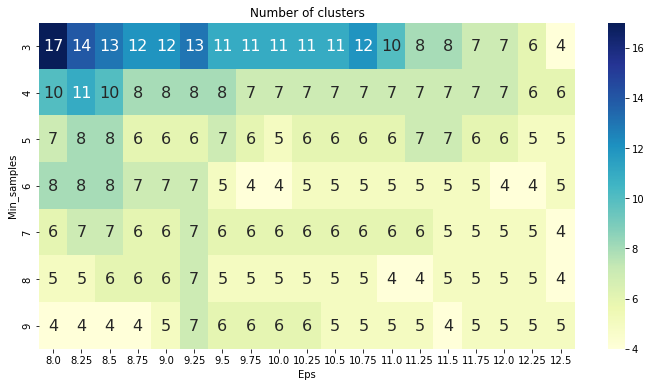

In [34]:
# 파라미터 값 별 계산된 클러스터 수
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
plt.show()

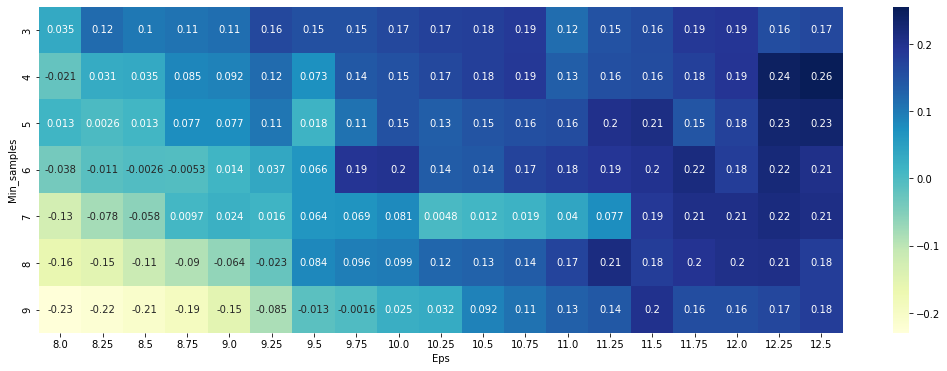

In [36]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

> 최대: eps=12.5, min_samples=4

In [35]:
DBS_clustering = DBSCAN(eps=12.5, min_samples=4).fit(X_numerics)

DBSCAN_clustered = X_numerics.copy()
DBSCAN_clustered.loc[:,'Cluster'] = DBS_clustering.labels_ # append labels to points

In [38]:
# 클러스터 별 크기
DBSCAN_clust_sizes = DBSCAN_clustered.groupby('Cluster').size().to_frame()
DBSCAN_clust_sizes.columns = ["DBSCAN_size"]
DBSCAN_clust_sizes

,DBSCAN_size
Cluster,
-1,18
0,112
1,8
2,34
3,24
4,4


> 이상치를 제외한 0-4 5개의 클러스터 생성

> 일부 클러스터는 4개, 8개의 관측치 밖에 없음 -> 총합 18개의 이상치

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



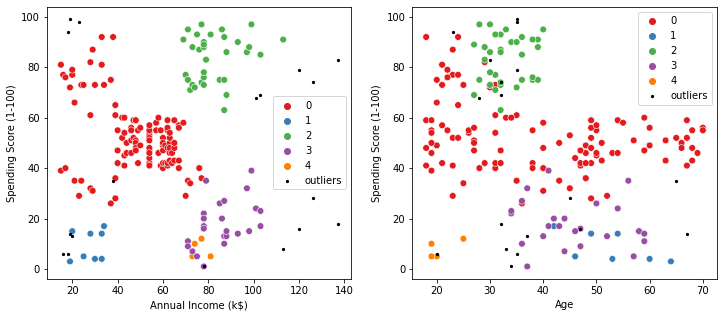

In [39]:
outliers = DBSCAN_clustered[DBSCAN_clustered['Cluster']==-1]

fig2, (axes) = plt.subplots(1,2,figsize=(12,5))


sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', ax=axes[0], palette='Set1', legend='full', s=45)

sns.scatterplot('Age', 'Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', palette='Set1', ax=axes[1], legend='full', s=45)

axes[0].scatter(outliers['Annual Income (k$)'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[1].scatter(outliers['Age'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[0].legend()
axes[1].legend()

plt.setp(axes[0].get_legend().get_texts(), fontsize='10')
plt.setp(axes[1].get_legend().get_texts(), fontsize='10')

plt.show()

### 4.3 Affinity Propagation

: 한 쌍의 점들 사이에서 그것이 수렴될 때까지 메시지를 보내는 개념을 중심으로 만들어진 군집화 알고리즘. 메시지들은 이 두 점이 서로 얼마나 유사한지를 측정하는 방법을 일컫음

- 최적의 군집 수 자동 찾기

- 높은 시간 복잡도

- 장점: 초기화 기준에 대한 민감도 부족

<주요 파라미터>
- 선호도: exempler 수를 제어하는 음수
- damping factor: 메시지 업데이트 시 수치 oscillation 방지

In [40]:
from sklearn.cluster import AffinityPropagation

In [45]:
no_of_clusters = []
preferences = range(-20000,-5000, 150) # arbitraty chosen range
af_sil_score = [] # silouette scores

for p in preferences:
    AF = AffinityPropagation(preference=p, max_iter=200).fit(X_numerics)
    no_of_clusters.append((len(np.unique(AF.labels_))))
    af_sil_score.append(silhouette_score(X_numerics, AF.labels_))
    
af_results = pd.DataFrame([preferences, no_of_clusters, af_sil_score], index=['preference','clusters', 'sil_score']).T
af_results.sort_values(by='sil_score', ascending=False).head() 
# display only 5 best scores

,preference,clusters,sil_score
63,-10550.0,6.0,0.451491
34,-14900.0,6.0,0.451491
18,-17300.0,6.0,0.451491
22,-16700.0,6.0,0.451440
37,-14450.0,6.0,0.451440


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



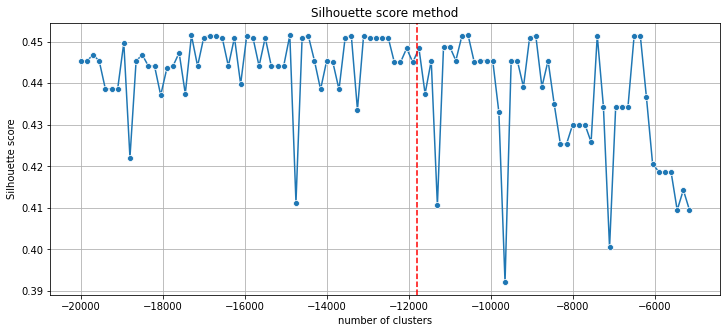

In [46]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(preferences, af_sil_score, marker='o', ax=ax)
ax.set_title("Silhouette score method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("Silhouette score")
ax.axvline(-11800, ls="--", c="red")
plt.grid()
plt.show()

In [47]:
AF = AffinityPropagation(preference=-11800).fit(X_numerics)

In [48]:
AF_clustered = X_numerics.copy()
AF_clustered.loc[:,'Cluster'] = AF.labels_ # append labels to points

In [49]:
AF_clust_sizes = AF_clustered.groupby('Cluster').size().to_frame()
AF_clust_sizes.columns = ["AF_size"]
AF_clust_sizes

,AF_size
Cluster,
0,22
1,22
2,44
3,39
4,34
5,39


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



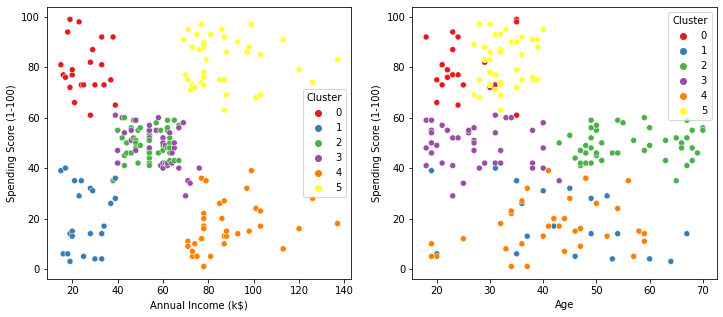

In [50]:
fig3, (ax_af) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)', data=AF_clustered,
                hue='Cluster', ax=ax_af[0], palette='Set1', legend='full')

sns.scatterplot('Age', 'Spending Score (1-100)', data=AF_clustered,
                hue='Cluster', palette='Set1', ax=ax_af[1], legend='full')

plt.setp(ax_af[0].get_legend().get_texts(), fontsize='10')
plt.setp(ax_af[1].get_legend().get_texts(), fontsize='10')
plt.show()

## 5. Comparison and discussion

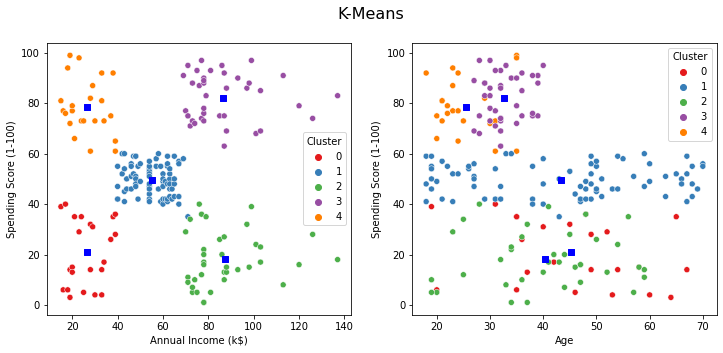

In [51]:
fig1.suptitle('K-Means', fontsize=16)
fig1

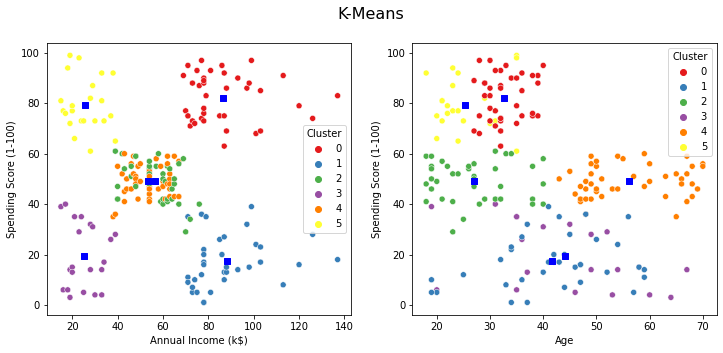

In [52]:
fig11.suptitle('K-Means', fontsize=16)
fig11

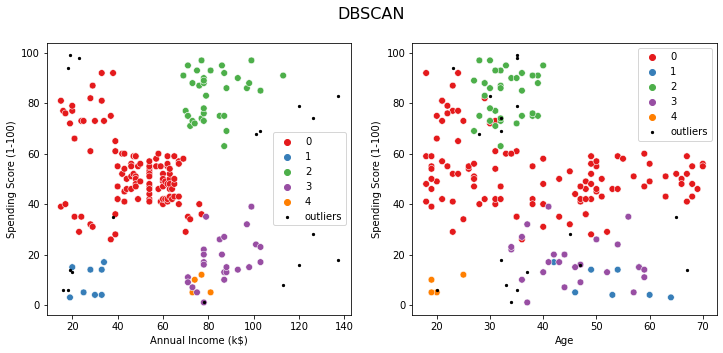

In [53]:
fig2.suptitle('DBSCAN', fontsize=16)
fig2

In [54]:
clusters = pd.concat([KM6_clust_sizes, DBSCAN_clust_sizes, AF_clust_sizes],axis=1, sort=False)
clusters

,KM_size,DBSCAN_size,AF_size
Cluster,,,
-1,NaN,18.0,NaN
0,39.0,112.0,22.0
1,35.0,8.0,22.0
2,38.0,34.0,44.0
3,21.0,24.0,39.0
4,45.0,4.0,34.0
5,22.0,NaN,39.0


서로 다른 클러스터 크기와 매기는 방식의 차이

> DBSCAN은 합리적인 클러스터 생성 못함 (밀도 인식 때문)

> K평균과 AP는 상대적으로 6개의 합리적인 클러스터를 생성함